In [3]:
import cv2
import operator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.signal import argrelextrema

C:\Users\Maria\anaconda3\python.exe
target video :C:/Users/Maria/Tesis/tesis/videos_20seg/abinader1.mp4
frame save directory: C:/Users/Maria/Tesis/tesis/frames_video
Using Local Maxima
500 50


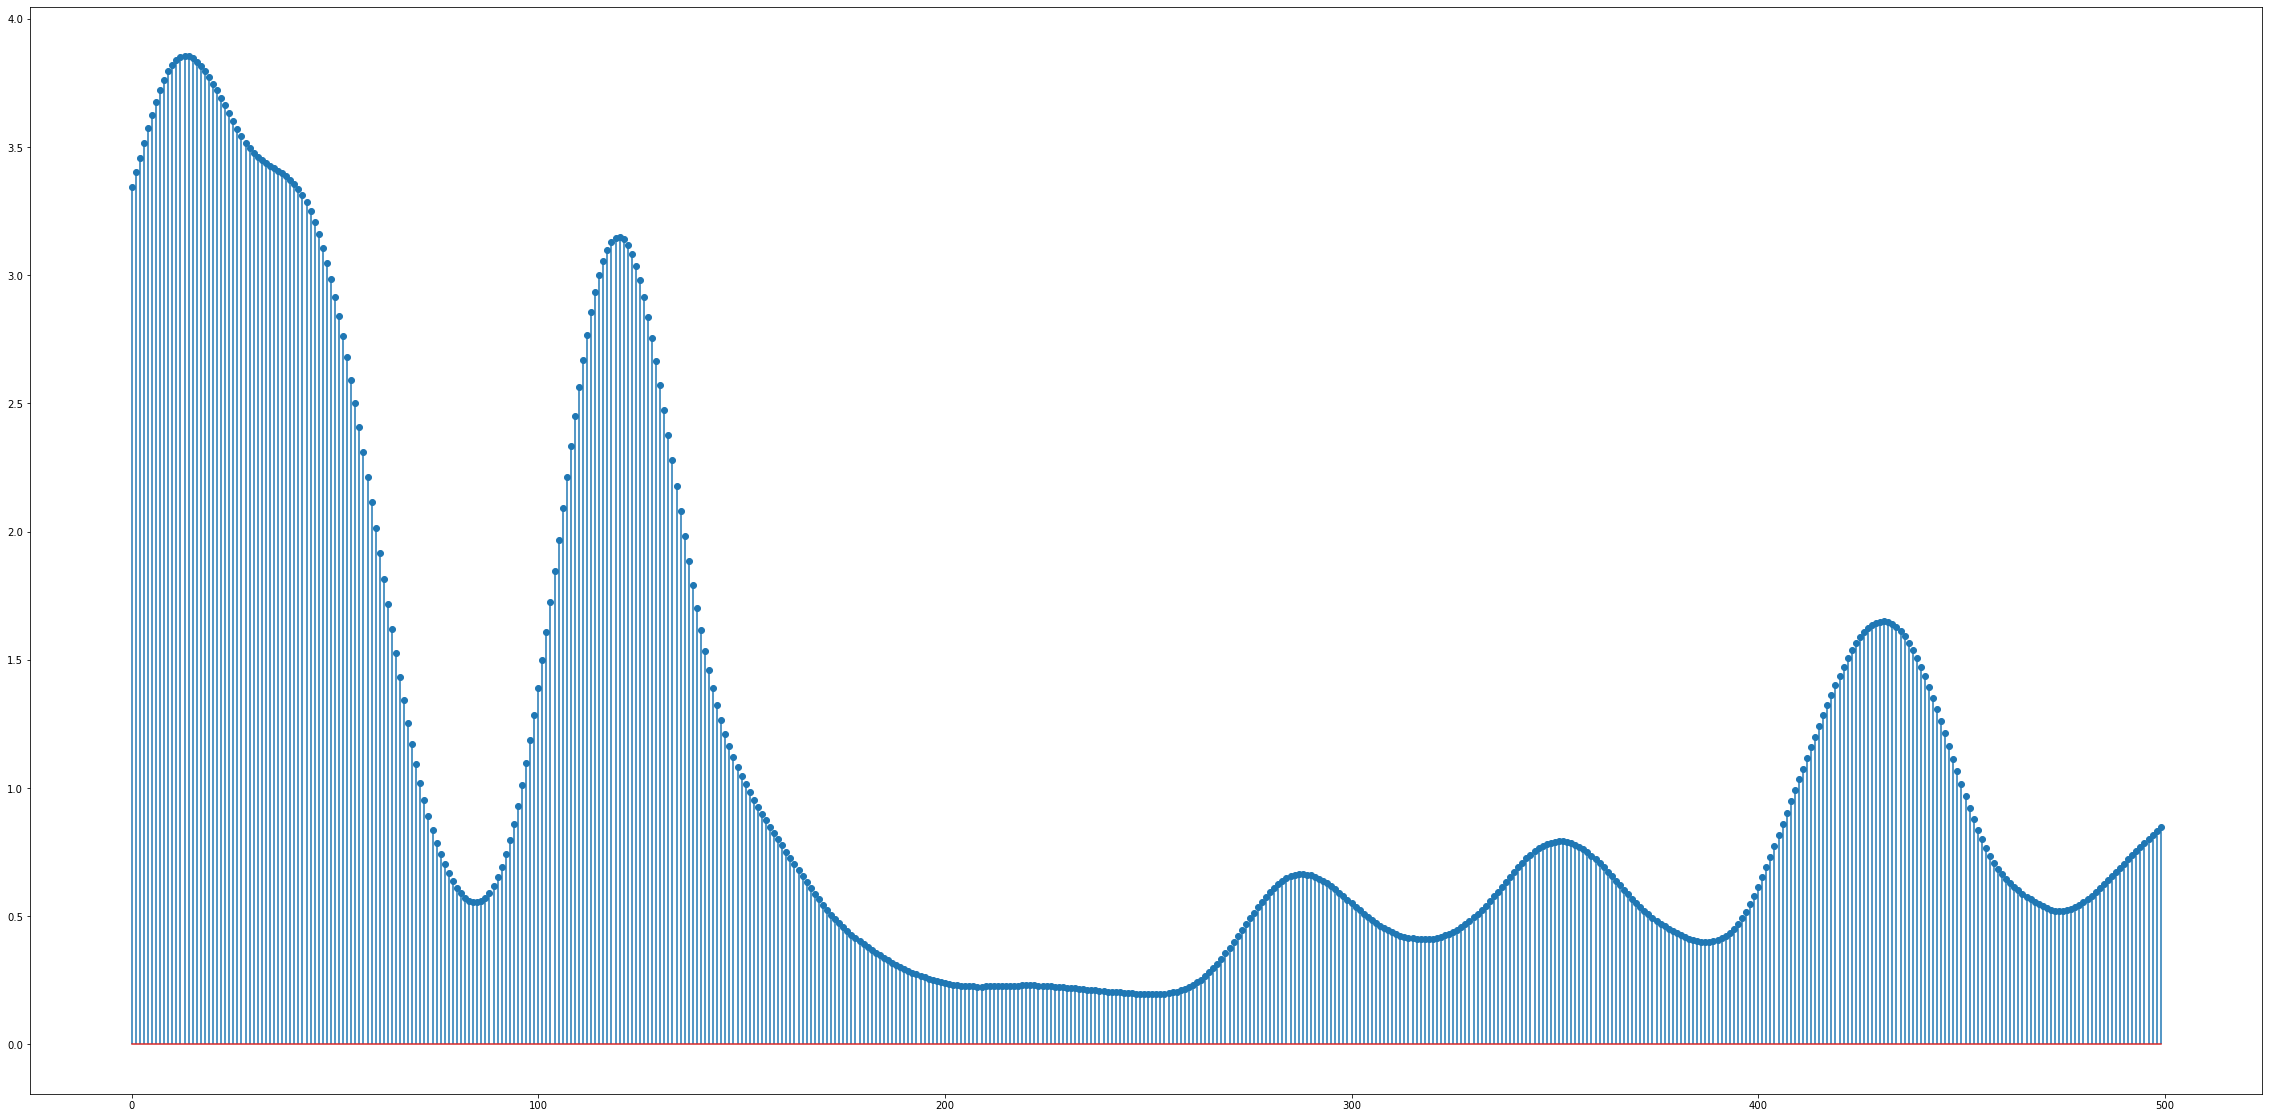

In [8]:
 def smooth(x, window_len=13, window='hanning'):
    print(len(x), window_len)
    s = np.r_[2 * x[0] - x[window_len:1:-1],
              x, 2 * x[-1] - x[-1:-window_len:-1]]

    if window == 'flat':  # media móvil
        w = np.ones(window_len, 'd')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w / w.sum(), s, mode='same')
    return y[window_len - 1:-window_len + 1]
 

class Frame:
    def __init__(self, id, diff):
        self.id = id
        self.diff = diff
 
    def __lt__(self, other):
        if self.id == other.id:
            return self.id < other.id
        return self.id < other.id
 
    def __gt__(self, other):
        return other.__lt__(self)
 
    def __eq__(self, other):
        return self.id == other.id and self.id == other.id
 
    def __ne__(self, other):
        return not self.__eq__(other)
 
 
def rel_change(a, b):
    x = (b - a) / max(a, b)
    print(x)
    return x
 
    
if __name__ == "__main__":
    print(sys.executable)
    # Establecimiento de criterios de umbral fijo Establecimiento de criterios de umbral fijo
    USE_THRESH = False
    # valor de umbral fijo Umbral fijo
    THRESH = 0.6
    # Establecimiento de criterios de umbral fijo Establecimiento de criterios de umbral fijo
    USE_TOP_ORDER = False
    #Establecimiento de criterios máximos localesEstablecimiento de criterios máximos locales
    USE_LOCAL_MAXIMA = True
    # Número de fotogramas mejor ordenados
    NUM_TOP_FRAMES = 50
     
    # Ruta de video del archivo fuente
    videopath= 'C:/Users/Maria/Tesis/tesis/videos_20seg/abinader1.mp4'
    #Directorio para almacenar los marcos procesados
    dir = 'C:/Users/Maria/Tesis/tesis/frames_video/resultados'
    
    # Si el directorio de archivos no existe, cree un directorio
    if not os.path.exists(dir):
        os.makedirs(dir)
    # suavizar el tamaño de la ventana Suavizar el tamaño de la ventana
    len_window = int(50)
    
    
    print("target video :" + videopath)
    print("frame save directory: " + dir)
    # cargar video y calcular la diferencia entre cuadros
    cap = cv2.VideoCapture(str(videopath)) 
    curr_frame = None
    prev_frame = None 
    frame_diffs = []
    frames = []
    success, frame = cap.read()
    i = 0 
    while(success):
        luv = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
        curr_frame = luv
        if curr_frame is not None and prev_frame is not None:
            #logic here
            diff = cv2.absdiff(curr_frame, prev_frame)#Obtener mapa de diferencias
            diff_sum = np.sum(diff)
            diff_sum_mean = diff_sum / (diff.shape[0] * diff.shape[1])# Marco promedio
            frame_diffs.append(diff_sum_mean)
            frame = Frame(i, diff_sum_mean)
            frames.append(frame)
        prev_frame = curr_frame
        i = i + 1
        success, frame = cap.read()   
    cap.release()
    
    # compute keyframe
    keyframe_id_set = set()
    if USE_TOP_ORDER:
        # ordenar la lista en orden descendente ordenar la lista en orden descendente
        frames.sort(key=operator.attrgetter("diff"), reverse=True)
        for keyframe in frames[:NUM_TOP_FRAMES]:
            keyframe_id_set.add(keyframe.id) 
    if USE_THRESH:
        print("Using Threshold")#Use umbral
        for i in range(1, len(frames)):
            if (rel_change(np.float(frames[i - 1].diff), np.float(frames[i].diff)) >= THRESH):
                keyframe_id_set.add(frames[i].id)   
    if USE_LOCAL_MAXIMA:
        print("Using Local Maxima")#Utilice el máximo local
        diff_array = np.array(frame_diffs)
        sm_diff_array = smooth(diff_array, len_window)#suave
        frame_indexes = np.asarray(argrelextrema(sm_diff_array, np.greater))[0]
        for i in frame_indexes:
            keyframe_id_set.add(frames[i - 1].id)
            
        plt.figure(figsize=(40, 20))
        plt.locator_params(tight=100)
        plt.stem(sm_diff_array)
        plt.savefig(dir + 'plot.png')
    
    # guardar todos los fotogramas clave como imagen Guardar todos los fotogramas clave como imagen
    cap = cv2.VideoCapture(str(videopath))
    curr_frame = None
    keyframes = []
    success, frame = cap.read()
    idx = 0
    while(success):
        if idx in keyframe_id_set:
            name = "keyframe_" + str(idx) + ".jpg"
            cv2.imwrite(dir + name, frame)
            keyframe_id_set.remove(idx)
        idx = idx + 1
        success, frame = cap.read()
    cap.release()